## Current 'clean' Modeling Notebook

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn import svm
import hdbscan
from sklearn.preprocessing import LabelEncoder,normalize,StandardScaler
from sklearn.decomposition import PCA
# import xgboost as xgb
# from xgboost import XGBClassifier

In [41]:
# train = pd.read_csv('../../../../datasets/Project4/workingfiles/train.csv')

In [42]:
train = pd.read_csv('~/Dropbox/DSI/train.csv')

In [43]:
cols = [i for i in train.columns]

In [44]:
# deal with NaNs
for i in train.columns[train.isnull().sum()>0]: # for all the columns with nans
    mean_avg_temp = train.loc[train[i].isnull()==True,'Tavg'].mean() # what is the mean Tavg
    mean_i_val = train.loc[train.Tavg==mean_avg_temp,i].mean() # what is i val for that Tavg
    train.loc[train[i].isnull()==True,'to_fill'] = mean_i_val
    train[i] = train[i].fillna(train.to_fill)
    train.drop('to_fill',axis=1,inplace=True)

In [45]:
dates = ['_date-'+str(i) for i in range(1,7)]
for i,v in enumerate(cols):
    try:
        if v in dates: # drops out the repeated date column
            train.drop(v,axis=1,inplace=True)
    except:
        pass
    try:
        if 'Date_date-' in v:
            train.drop(v,axis=1,inplace=True)
    except:
        pass

In [46]:
le = LabelEncoder()
le.fit(train.Species)
train['mosquito'] = le.transform(train.Species)
le.fit(train.Trap)
train['trap_e'] = le.transform(train.Trap)

In [47]:
train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,...,SG_date-6,PO_date-6,PL_date-6,SN_date-6,Trap_Mosquitos_today,Trap_Species_today,min_Wnv_species_today,Epoch,mosquito,trap_e
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,0,0,0,0,2,1,0,1180396800,2,1
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,0,0,0,0,2,1,0,1180396800,3,1
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,...,0,0,0,0,1,1,0,1180396800,3,6
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,0,0,0,0,5,1,0,1180396800,2,14
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,0,0,0,0,5,4,0,1180396800,3,14


In [48]:
weather_cats = train.columns[300:333].tolist()

In [49]:
new_cats = []
for c in range(1,7):
    for w in weather_cats:
        c_string = str(c)
        cat = str(w)+'_date-'+c_string
        new_cats.append(cat)

In [50]:
weather_cats = weather_cats + new_cats

In [51]:
scale_exclude = ['Date', 'mosquito', 'Species', 'Trap', 'trap_e','Address', 'Block', 'Street', 
               'AddressNumberAndStreet', 'AddressAccuracy','WnvPresent', 'Coordinates', 'Weather_Station',
                'Trap_Mosquitos_today','Trap_Species_today','min_Wnv_species_today','Epoch',
                'Latitude','Longitude']

In [52]:
for c in weather_cats:
    scale_exclude.append(c)

In [53]:
scale_cols = [x for x in train.columns if x not in scale_exclude]

In [54]:
train.dropna(inplace=True)

In [55]:
# Scaling all non-categorical numerical values using standard scaler

std_scale = StandardScaler()
train[scale_cols] = std_scale.fit_transform(train[scale_cols])

In [56]:
model_exclude_cols = ['Date', 'Species', 'Trap', 'Address', 'Block', 'Street', 
               'AddressNumberAndStreet', 'AddressAccuracy','WnvPresent', 'Coordinates', 'Weather_Station']

In [57]:
X_cols_full = [i for i in train.columns if i not in model_exclude_cols]

In [58]:
# Defining X (2 versions, one of which will be PCA'd), and y
X = train[X_cols_full]
y = train.WnvPresent

In [59]:
X.head()

,Latitude,Longitude,NumMosquitos,T152_dist,T153_dist,T019_dist,T018_dist,T156_dist,T157_dist,T154_dist,...,SG_date-6,PO_date-6,PL_date-6,SN_date-6,Trap_Mosquitos_today,Trap_Species_today,min_Wnv_species_today,Epoch,mosquito,trap_e
0,1.025705,-1.082955,-0.730363,0.053344,-1.068747,-0.859025,-0.849954,0.781999,0.691519,-1.088201,...,0,0,0,0,2,1,0,1180396800,2,1
1,1.025705,-1.082955,-0.730363,0.053344,-1.068747,-0.859025,-0.849954,0.781999,0.691519,-1.088201,...,0,0,0,0,2,1,0,1180396800,3,1
2,1.383620,-0.750292,-0.730363,0.579959,-0.651069,-0.940832,-1.234347,1.355409,1.089867,-0.762032,...,0,0,0,0,1,1,0,1180396800,3,6
3,1.197988,-1.332840,-0.730363,0.530294,-0.727930,-0.619368,-0.754953,1.158362,1.151985,-0.762408,...,0,0,0,0,5,1,0,1180396800,2,14
4,1.197988,-1.332840,-0.543421,0.530294,-0.727930,-0.619368,-0.754953,1.158362,1.151985,-0.762408,...,0,0,0,0,5,4,0,1180396800,3,14


In [66]:
# TTS for non-PCA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, stratify=y)

In [67]:
# PCA-ifying 
pca = PCA(n_components=31,svd_solver='full') # 30 components describe 85% of variance
pca.fit(X)
X_pca = pca.transform(X)
# print pca.explained_variance_ratio_
print pca.explained_variance_ratio_.sum()


0.98412275314


In [68]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y,stratify=y, test_size=0.33)

### Model Eval Formulas

In [69]:
## Non-PCA
def evaluate_model(m):
    model = m.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test,y_pred,labels =[0,1])
    class_report = classification_report
    print m,'\n'
    print "Accuracy Score:\t{:0.3}".format(score.round(3)),'\n\n'
    crossval = cross_val_score(m, X, y,cv=7, n_jobs=-1)
    print "Cross Val Scores:", crossval,'\n'
    print "Cross Val mean ± Std. Dev:{:0.3}".format(np.mean(crossval), ' ± ',np.std(crossval)),'\n'
    print "Predicted Totals:"
    for i,v in enumerate(np.bincount(y)):
        print "class "+str(i)+':' , v
    print "\nConfusion Matrix:"
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[1,0]))
    confusion = pd.DataFrame(conmat, index=['Actual 1', 'Actual 0'],
                         columns=['Predicted 1','Predicted 0'])
    print(confusion),'\n'
    print "Classification Report:"
    print(classification_report(y_test, y_pred, target_names=['0','1']))
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specificity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [70]:
## PCA
def evaluate_model_PCA(m):
    model = m.fit(X_train_pca,y_train_pca)
    y_pred_pca = model.predict(X_test_pca)
    score = accuracy_score(y_test_pca, y_pred_pca)
    conf_matrix = confusion_matrix(y_test_pca,y_pred_pca,labels =[0,1])
    class_report = classification_report
    print m,'\n'
    print "Accuracy Score (PCA):\t{:0.3}".format(score.round(3)),'\n\n'
    crossval = cross_val_score(m, X_pca, y,cv=7, n_jobs=-1)
    print "Cross Val Scores (PCA):", crossval,'\n'
    print "Cross Val mean ± Std. Dev:{:0.3}".format(np.mean(crossval), ' ± ',np.std(crossval)),'\n'
    print "Predicted Totals (PCA):"
    for i,v in enumerate(np.bincount(y)):
        print "class "+str(i)+':' , v
    print "\nConfusion Matrix (PCA):"
    conmat = np.array(confusion_matrix(y_test_pca, y_pred_pca, labels=[1,0]))
    confusion = pd.DataFrame(conmat, index=['Actual 1', 'Actual 0'],
                         columns=['Predicted 1','Predicted 0'])
    print(confusion),'\n'
    print "Classification Report (PCA):"
    print(classification_report(y_test_pca, y_pred_pca, target_names=['0','1']))
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test_pca, y_pred_pca)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specificity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

## Models

### KNN

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform') 

Accuracy Score:	0.936 


Cross Val Scores: [ 0.93205216  0.64927934  0.93127148  0.92783505  0.88728522  0.90171821
  0.79243986] 

Cross Val mean ± Std. Dev:0.86 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1           19          155
Actual 0           61         3128 

Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.98      0.97      3189
          1       0.24      0.11      0.15       174

avg / total       0.92      0.94      0.92      3363



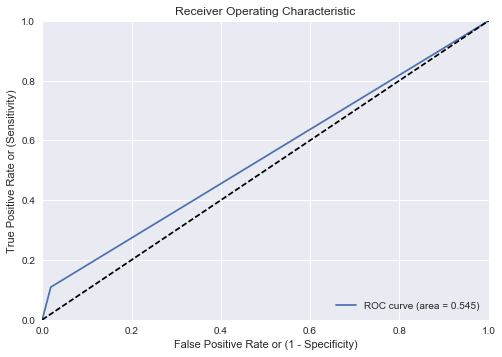

In [54]:
# All data

KNN = KNeighborsClassifier(n_neighbors=3)
evaluate_model(KNN)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform') 

Accuracy Score (PCA):	0.936 


Cross Val Scores (PCA): [ 0.94097461  0.64996568  0.92783505  0.93402062  0.89690722  0.8975945
  0.82405498] 

Cross Val mean ± Std. Dev:0.867 

Predicted Totals (PCA):
class 0: 9662
class 1: 527

Confusion Matrix (PCA):
          Predicted 1  Predicted 0
Actual 1           19          155
Actual 0           61         3128 

Classification Report (PCA):
             precision    recall  f1-score   support

          0       0.95      0.98      0.97      3189
          1       0.24      0.11      0.15       174

avg / total       0.92      0.94      0.92      3363



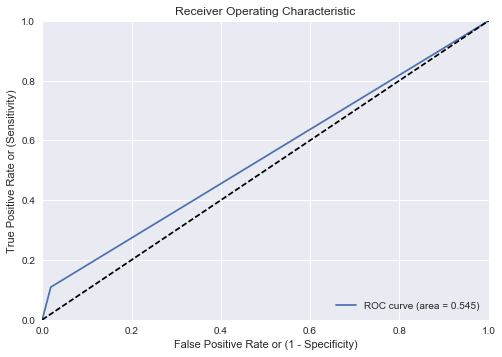

In [64]:
# PCA
evaluate_model_PCA(KNN)

### AdaBoost

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          learning_rate=1.0, n_estimators=50, random_state=None) 

Accuracy Score:	0.932 


Cross Val Scores: [ 0.94783802  0.60947152  0.91065292  0.94845361  0.88797251  0.89621993
  0.67835052] 

Cross Val mean ± Std. Dev:0.84 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1           43          131
Actual 0           99         3090 

Classification Report:
             precision    recall  f1-score   support

          0       0.96      0.97      0.96      3189
          1       0.30

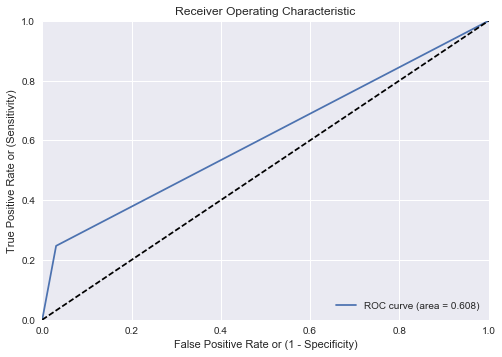

In [57]:
rf = RandomForestClassifier(max_features = 10)
ada = AdaBoostClassifier(base_estimator=rf)
evaluate_model(ada)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          learning_rate=1.0, n_estimators=50, random_state=None) 

Accuracy Score (PCA):	0.936 


Cross Val Scores (PCA): [ 0.94783802  0.43445436  0.87560137  0.94845361  0.87972509  0.85017182
  0.65223368] 

Cross Val mean ± Std. Dev:0.798 

Predicted Totals (PCA):
class 0: 9662
class 1: 527

Confusion Matrix (PCA):
          Predicted 1  Predicted 0
Actual 1           29          145
Actual 0           70         3119 

Classification Report (PCA):
             precision    recall  f1-score   support

          0       0.96      0.98      0.97  

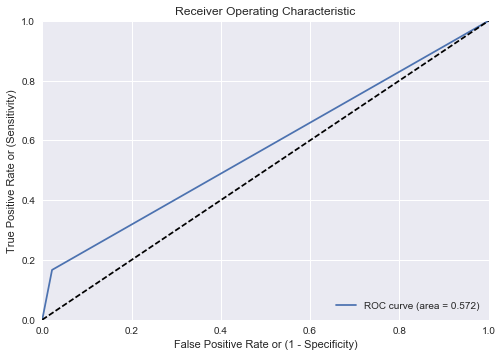

In [65]:
# PCA
evaluate_model_PCA(ada)

### Random Forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.8, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False) 

Accuracy Score:	0.943 


Cross Val Scores: [ 0.94783802  0.27316404  0.81924399  0.94845361  0.67147766  0.69690722
  0.11408935] 

Cross Val mean ± Std. Dev:0.639 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1           25          149
Actual 0           42         3147 

Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      3189
          1       0.37      0.14      0.21       174

avg / total       0.92      0.94      0.93      3363



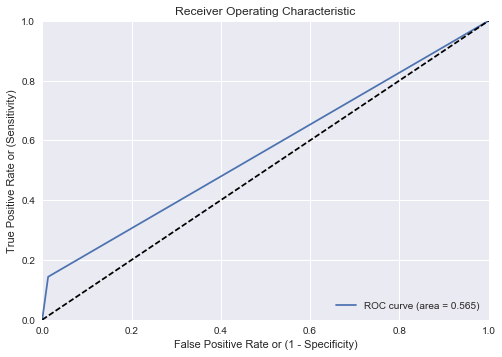

In [66]:
#Non PCA
RF_solo = RandomForestClassifier(max_features=.8)
evaluate_model(RF_solo)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.8, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False) 

Accuracy Score (PCA):	0.941 


Cross Val Scores (PCA): [ 0.94371997  0.40494166  0.86391753  0.91890034  0.81443299  0.76975945
  0.63092784] 

Cross Val mean ± Std. Dev:0.764 

Predicted Totals (PCA):
class 0: 9662
class 1: 527

Confusion Matrix (PCA):
          Predicted 1  Predicted 0
Actual 1           24          150
Actual 0           47         3142 

Classification Report (PCA):
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      3189
          1       0.34      0.14      0.20       174

avg / total       0.92      0.94      0.93      3363



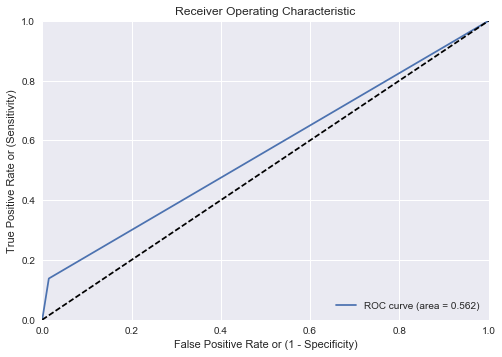

In [67]:
# PCA version
evaluate_model_PCA(RF_solo)

### SVMs

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 

Accuracy Score:	0.944 


Cross Val Scores: [ 0.94783802  0.29512697  0.82955326  0.94707904  0.85910653  0.82542955
  0.47285223] 

Cross Val mean ± Std. Dev:0.74 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1           10          164
Actual 0           25         3164 

Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      3189
          1       0.29      0.06      0.10       174

avg / total       0.92      0.94      0.93      3363



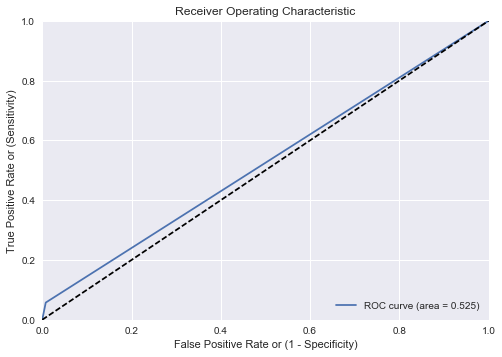

In [68]:
# Non PCA
SVM = svm.SVC(C=10, kernel='rbf', probability=True)
evaluate_model(SVM)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 

Accuracy Score (PCA):	0.937 


Cross Val Scores (PCA): [ 0.94783802  0.65888813  0.91065292  0.94570447  0.89415808  0.88109966
  0.79312715] 

Cross Val mean ± Std. Dev:0.862 

Predicted Totals (PCA):
class 0: 9662
class 1: 527

Confusion Matrix (PCA):
          Predicted 1  Predicted 0
Actual 1           22          152
Actual 0           59         3130 

Classification Report (PCA):
             precision    recall  f1-score   support

          0       0.95      0.98      0.97      3189
          1       0.27      0.13      0.17       174

avg / total       0.92      0.94      0.93      3363



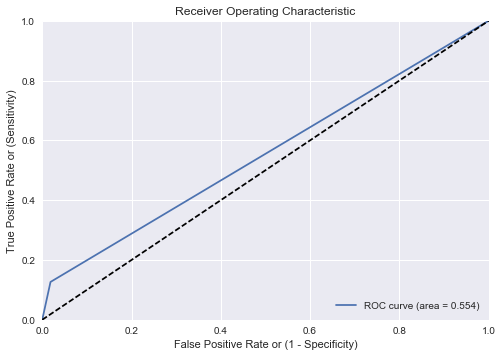

In [69]:
#  PCA
SVM = svm.SVC(C=10, kernel='rbf', probability=True)
evaluate_model_PCA(SVM)

### Logistic Regression

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 

Accuracy Score:	0.949 


Cross Val Scores: [ 0.93342485  0.18599863  0.78556701  0.88522337  0.64467354  0.53127148
  0.29965636] 

Cross Val mean ± Std. Dev:0.609 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1           17          157
Actual 0           16         3173 

Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      3189
          1       0.52      0.10      0.16       174

avg / total       0.93      0.95      0.93      3363



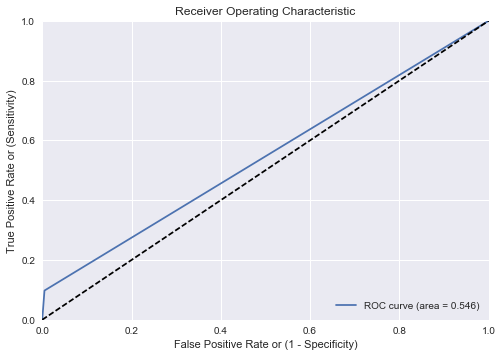

In [70]:
# Non PCA
logreg = LogisticRegression(C=2, penalty='l1')
evaluate_model(logreg)

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 

Accuracy Score (PCA):	0.948 


Cross Val Scores (PCA): [ 0.94783802  0.81331503  0.91408935  0.86116838  0.86872852  0.94845361
  0.80687285] 

Cross Val mean ± Std. Dev:0.88 

Predicted Totals (PCA):
class 0: 9662
class 1: 527

Confusion Matrix (PCA):
          Predicted 1  Predicted 0
Actual 1            0          174
Actual 0            0         3189 

Classification Report (PCA):
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      3189
          1       0.00      0.00      0.00       174

avg / total       0.90      0.95      0.92      3363



/Users/michaelsanders/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


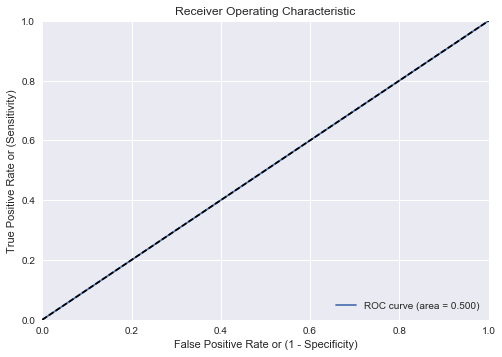

In [71]:
#  PCA
logreg = LogisticRegression(C=2, penalty='l1')
evaluate_model_PCA(logreg)

## XGBoost

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1) 

Accuracy Score:	0.949 


Cross Val Scores: [ 0.94783802  0.31914894  0.93127148  0.94845361  0.86666667  0.88591065
  0.11546392] 

Cross Val mean ± Std. Dev:0.716 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1           18          156
Actual 0           17         3172 

Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      3189
          1       0.51      0.10      0.17       174

avg / total       0.93      0.95      0.93      3363



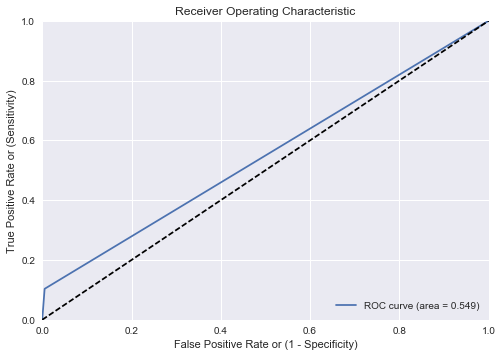

In [27]:
# Non PCA
XGB = XGBClassifier()
evaluate_model(XGB)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1) 

Accuracy Score (PCA):	0.949 


Cross Val Scores (PCA): [ 0.94783802  0.50652025  0.93814433  0.94845361  0.88591065  0.9443299
  0.60412371] 

Cross Val mean ± Std. Dev:0.825 

Predicted Totals (PCA):
class 0: 9662
class 1: 527

Confusion Matrix (PCA):
          Predicted 1  Predicted 0
Actual 1            6          168
Actual 0            4         3185 

Classification Report (PCA):
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      3189
          1       0.60      0.03      0.07       174

avg / total       0.93      0.95      0.93      3363



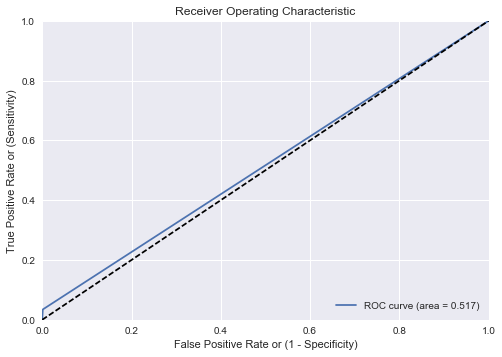

In [28]:
#  PCA
XGB = XGBClassifier()
evaluate_model_PCA(XGB)

### HDSCAN

In [73]:
clusterer = hdbscan.HDBSCAN()

In [74]:
# Non_PCA
clusterer.fit(X)
cluster_labels = clusterer.labels_
print(clusterer.labels_.max())

587


In [75]:
# PCA
clusterer.fit(X_pca)
cluster_labels_PCA = clusterer.labels_
print(clusterer.labels_.max())

426


In [80]:
X_clusters = X.copy()
X_clusters_pca = X_pca.copy()

In [92]:
X_clusters['HDBSCAN-full'] = cluster_labels
np.append(X_clusters_pca,cluster_labels_PCA)

array([  71.74695984,   12.37684012,   -8.75197407, ...,  217.        ,
         42.        ,   -1.        ])

In [93]:
X_clusters.drop('NumMosquitos', axis=1, inplace=True)

In [96]:
## TTS for non-PCA clustered
X_clust_train, X_clust_test, y_clust_train, y_clust_test = train_test_split(X_clusters, y, test_size=.33, stratify=y)

In [97]:
## TTS for PCA clustered
X_ClPca_train, X_ClPCA_test, y_ClPca_train, y_ClPca_test = train_test_split(X_clusters_pca, y, test_size = .33, stratify=y)

In [99]:
## Clusters non PCA
def evaluate_model_Cluster(m):
    model = m.fit(X_clust_train,y_clust_train)
    y_pred_clus = model.predict(X_clust_train)
    score = accuracy_score(y_clust_test, y_clust_test)
    conf_matrix = confusion_matrix(y_clust_test,y_pred_clus,labels =[0,1])
    class_report = classification_report
    print m,'\n'
    print "Accuracy Score (PCA):\t{:0.3}".format(score.round(3)),'\n\n'
    crossval = cross_val_score(m, X_clusters, y,cv=7, n_jobs=-1)
    print "Cross Val Scores (PCA):", crossval,'\n'
    print "Cross Val mean ± Std. Dev:{:0.3}".format(np.mean(crossval), ' ± ',np.std(crossval)),'\n'
    print "Predicted Totals (PCA):"
    for i,v in enumerate(np.bincount(y)):
        print "class "+str(i)+':' , v
    print "\nConfusion Matrix (PCA):"
    conmat = np.array(confusion_matrix(y_clust_test, y_pred_clus, labels=[1,0]))
    confusion = pd.DataFrame(conmat, index=['Actual 1', 'Actual 0'],
                         columns=['Predicted 1','Predicted 0'])
    print(confusion),'\n'
    print "Classification Report (PCA):"
    print(classification_report(y_clust_test, y_pred_clus, target_names=['0','1']))
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_clust_test, y_pred_clus)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specificity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [100]:
## Clusters PCA
def evaluate_model_Cluster_PCA(m):
    model = m.fit(X_ClPca_train,y_ClPca_train)
    y_pred_pca_clus = model.predict(X_ClPca_train)
    score = accuracy_score(y_ClPca_test, y_ClPca_test)
    conf_matrix = confusion_matrix(y_ClPca_test,y_pred_pca_clus,labels =[0,1])
    class_report = classification_report
    print m,'\n'
    print "Accuracy Score (PCA):\t{:0.3}".format(score.round(3)),'\n\n'
    crossval = cross_val_score(m, X_clusters_pca, y,cv=7, n_jobs=-1)
    print "Cross Val Scores (PCA):", crossval,'\n'
    print "Cross Val mean ± Std. Dev:{:0.3}".format(np.mean(crossval), ' ± ',np.std(crossval)),'\n'
    print "Predicted Totals (PCA):"
    for i,v in enumerate(np.bincount(y)):
        print "class "+str(i)+':' , v
    print "\nConfusion Matrix (PCA):"
    conmat = np.array(confusion_matrix(y_ClPca_test, y_pred_pca_clus, labels=[1,0]))
    confusion = pd.DataFrame(conmat, index=['Actual 1', 'Actual 0'],
                         columns=['Predicted 1','Predicted 0'])
    print(confusion),'\n'
    print "Classification Report (PCA):"
    print(classification_report(y_ClPca_test, y_pred_pca_clus, target_names=['0','1']))
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_ClPca_test, y_pred_pca_clus)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specificity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
## XG boost with clusters, non PCA

